# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [29]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [31]:
import os
os.getcwd()

'/data/ephemeral/home/code'

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [3]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [34]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [4]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [5]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [6]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [7]:
concat['계약년월'] = concat['계약년월'].astype(str)

concat['계약년'] = concat['계약년월'].str[:4]

concat['계약년'] = concat['계약년'].astype(int)

### 지번 null없애기

In [8]:
concat['본번'] = concat['본번'].fillna(-1)
concat['부번'] = concat['부번'].fillna(-1)

concat['본번'] = concat['본번'].astype(int).astype(str).replace({-1: np.nan})
concat['부번'] = concat['부번'].astype(int).astype(str).replace({-1: np.nan})

concat['지번_temp'] = concat['본번'] + '-' + concat['부번']

In [9]:
concat['번지'] = concat['번지'].fillna(concat['지번_temp'])
concat['번지'].isnull().sum()

concat = concat.drop('지번_temp', axis=1)

concat['번지'].value_counts()

13        4670
17        4600
10        4577
347       4291
481       4191
          ... 
650-1        1
938-23       1
638-36       1
58-3         1
36-19        1
Name: 번지, Length: 6580, dtype: int64

In [10]:
# 해제사유발생 = 1, 미발생 = 0 으로 바꾸기

concat['거래취소여부'] = concat['해제사유발생일'].notnull().astype(int)

concat['거래취소여부'].value_counts()

concat = concat.drop(columns = '해제사유발생일',  errors='ignore')

In [11]:
# 불필요한 컬럼 제거

drop_columns = ['아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지',
                'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-관리방식', 'k-난방방식', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
                'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', '단지승인일',
                'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '단지신청일'
                ]

concat = concat.drop(columns = drop_columns,  errors='ignore')

In [15]:
# 거래일 건물연식

concat['거래일건물연식'] = concat['계약년'] - concat['건축년도']

In [16]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                        0
번지                         0
본번                         0
부번                         0
전용면적                       0
계약년월                       0
계약일                        0
층                          0
건축년도                       0
k-단지분류(아파트,주상복합등등)    877273
k-세대타입(분양형태)          876125
k-복도유형                876454
k-전체동수                877207
k-전체세대수               876125
k-건설사(시공사)            877637
건축면적                  876279
주차대수                  876277
좌표X                   876232
좌표Y                   876232
target                  9272
is_test                    0
계약년                        0
거래취소여부                     0
거래일건물연식                    0
dtype: int64

In [ ]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [ ]:
# # Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
# print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
# print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

In [17]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   시군구                 1128094 non-null  object 
 1   번지                  1128094 non-null  object 
 2   본번                  1128094 non-null  object 
 3   부번                  1128094 non-null  object 
 4   전용면적                1128094 non-null  float64
 5   계약년월                1128094 non-null  object 
 6   계약일                 1128094 non-null  int64  
 7   층                   1128094 non-null  int64  
 8   건축년도                1128094 non-null  int64  
 9   k-단지분류(아파트,주상복합등등)  250821 non-null   object 
 10  k-세대타입(분양형태)        251969 non-null   object 
 11  k-복도유형              251640 non-null   object 
 12  k-전체동수              250887 non-null   float64
 13  k-전체세대수             251969 non-null   float64
 14  k-건설사(시공사)          250457 non-null   object 
 15  건축면적              

In [18]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat['본번'] = concat['본번'].astype('str')
concat['부번'] = concat['부번'].astype('str')

In [53]:
concat['주소'] = concat['시군구'] + '' + concat['번지']

concat['주소'].value_counts()

서울특별시 송파구 신천동17        4372
서울특별시 강북구 미아동1353      4049
서울특별시 동작구 사당동105       3606
서울특별시 성북구 돈암동609-1     3519
서울특별시 노원구 중계동502-1     3327
                       ... 
서울특별시 구로구 구로동779-26       1
서울특별시 마포구 용강동495-3        1
서울특별시 은평구 불광동281-89       1
서울특별시 은평구 녹번동91-7         1
서울특별시 중구 입정동277           1
Name: 주소, Length: 8955, dtype: int64

In [19]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '계약년', '거래취소여부', '거래일건물연식']
범주형 변수: ['시군구', '번지', '본번', '부번', '계약년월', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-복도유형', 'k-건설사(시공사)']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [20]:
# 범주형 변수에 대한 보간
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [21]:
concat.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구                   0
번지                    0
본번                    0
부번                    0
전용면적                  0
계약년월                  0
계약일                   0
층                     0
건축년도                  0
k-단지분류(아파트,주상복합등등)    0
k-세대타입(분양형태)          0
k-복도유형                0
k-전체동수                0
k-전체세대수               0
k-건설사(시공사)            0
건축면적                  0
주차대수                  0
좌표X                   0
좌표Y                   0
target                0
is_test               0
계약년                   0
거래취소여부                0
거래일건물연식               0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

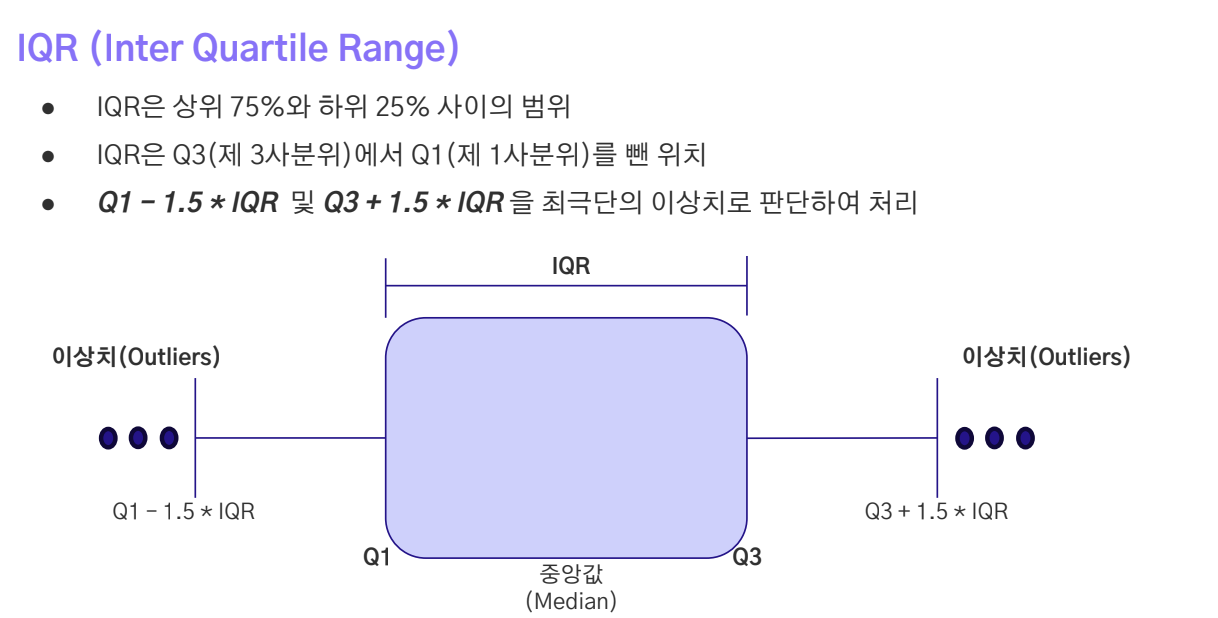

In [22]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat.shape)

(1128094, 24)


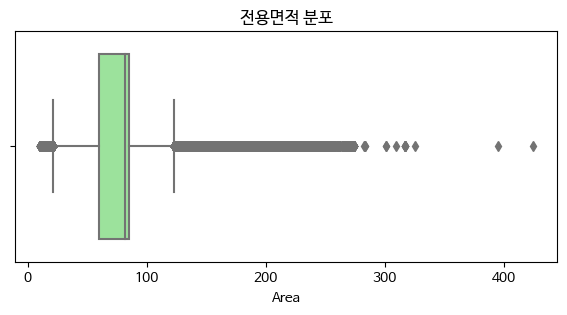

In [23]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [24]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [25]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat, '전용면적')

In [26]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1038846, 24)


In [27]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1029574
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [28]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

# concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [29]:
concat_select.columns

Index(['번지', '본번', '부번', '전용면적', '계약일', '층', '건축년도', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-복도유형', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', '건축면적',
       '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '계약년', '거래취소여부', '거래일건물연식',
       '구', '동', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [30]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [31]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [32]:
concat_select.columns

Index(['번지', '본번', '부번', '전용면적', '계약일', '층', '건축년도', 'k-단지분류(아파트,주상복합등등)',
       'k-세대타입(분양형태)', 'k-복도유형', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', '건축면적',
       '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '계약년', '거래취소여부', '거래일건물연식',
       '구', '동', '계약월', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [33]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.038846e+06
mean     1.998583e+03
std      9.132471e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [34]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# 노후건축물 기준에 맞추어 거래일 기준 20년 미만일 시 신축으로 분류
concat_select['신축여부'] = concat_select['거래일건물연식'].apply(lambda x: 1 if x < 20 else 0)

In [35]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,전용면적,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,...,target,is_test,계약년,거래취소여부,거래일건물연식,구,동,계약월,강남여부,신축여부
0,658-1,658,1,79.97,8,3,1987,아파트,분양,계단식,...,124000.0,0,2017,0,30,강남구,개포동,12,1,0


In [ ]:
import pandas as pd

concat_selected = pd.read_csv('../data/concat_select_with_coordinates.csv')


In [11]:
concat_selected.value_counts()

시군구               번지      본번     부번    아파트명      전용면적     계약년월      계약일   층     건축년도    k-단지분류(아파트,주상복합등등)  k-세대타입(분양형태)  k-복도유형  k-난방방식  k-전체동수  k-전체세대수  k-건설사(시공사)  k-사용검사일-사용승인일          k-연면적     k-주거전용면적  k-관리비부과면적  k-전용면적별세대현황(60㎡이하)  k-전용면적별세대현황(60㎡~85㎡이하)  k-85㎡~135㎡이하  k-수정일자                 건축면적      주차대수    기타/의무/임대/임의=1/2/3/4  단지승인일                  좌표X         좌표Y        target    is_test
서울특별시 성동구 금호동2가   1       1.0    0.0   신금호파크자이   84.980   202012.0  9.0   12.0  2016.0  아파트                 기타            혼합식     개별난방    10.0    1156.0   GS건설        2016-04-20 00:00:00.0  153669.0  73699.0   151182.0   801.0               336.0                   19.0          2023-09-25 05:43:19.0  8273.87   1289.0  의무                   2019-07-18 09:42:35.0  127.017996  37.554491  168000.0  0.0        4
서울특별시 은평구 진관동     60      60.0   0.0   은평뉴타운솔하임  19.839   202301.0  7.0   19.0  2017.0  주상복합                분양            혼합식     지역난방    3.0     260.0    (주)삼전건설     2017-09-28 00:00:0

In [36]:
concat_select.shape

(1038846, 27)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [4]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_selected.query('is_test==0')
dt_test = concat_selected.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(455215, 32) (0, 32)


/tmp/ipykernel_281399/1127542400.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train.drop(['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_281399/1127542400.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test.drop(['is_test'], axis = 1, inplace=True)


In [6]:
dt_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     0 non-null      object 
 1   번지                      0 non-null      object 
 2   본번                      0 non-null      float64
 3   부번                      0 non-null      float64
 4   아파트명                    0 non-null      object 
 5   전용면적                    0 non-null      float64
 6   계약년월                    0 non-null      float64
 7   계약일                     0 non-null      float64
 8   층                       0 non-null      float64
 9   건축년도                    0 non-null      float64
 10  k-단지분류(아파트,주상복합등등)      0 non-null      object 
 11  k-세대타입(분양형태)            0 non-null      object 
 12  k-복도유형                  0 non-null      object 
 13  k-난방방식                  0 non-null      object 
 14  k-전체동수                  0 non-null      float64
 15  k

In [38]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

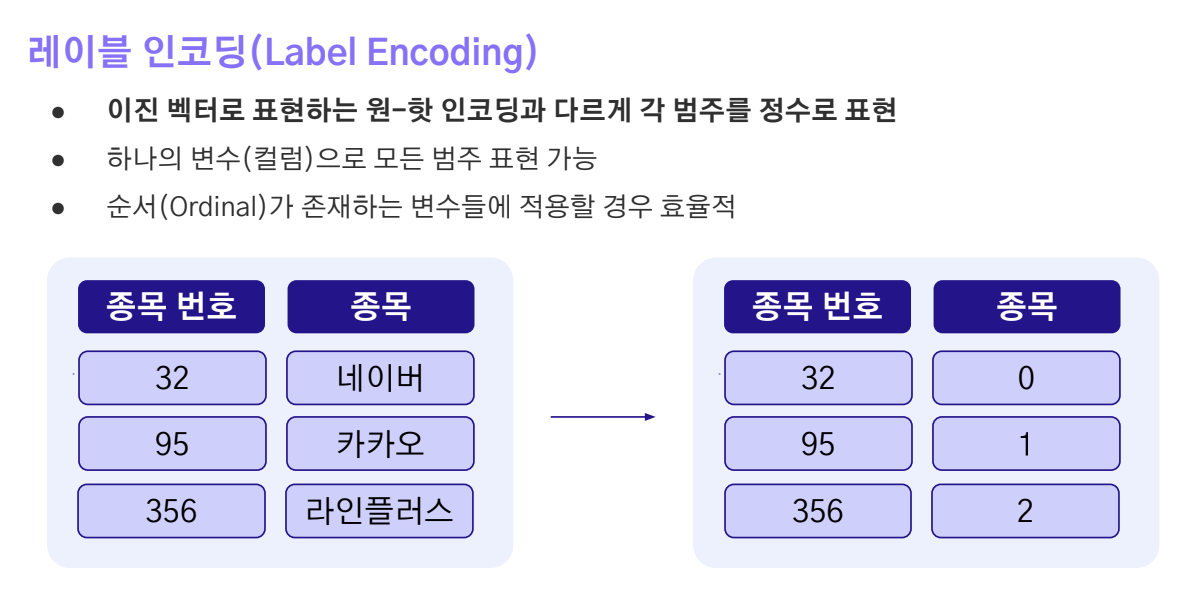

In [40]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '계약년', '거래취소여부', '거래일건물연식', '강남여부', '신축여부']
범주형 변수: ['번지', '본번', '부번', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-복도유형', 'k-건설사(시공사)', '구', '동', '계약월']


In [41]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


In [42]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,전용면적,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-복도유형,...,좌표Y,target,계약년,거래취소여부,거래일건물연식,구,동,계약월,강남여부,신축여부
0,4284,1115,2,79.97,8,3,1987,3,2,1,...,37.476763,124000.0,2017,0,30,0,8,11,1,0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [43]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [44]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [45]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [46]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 5885.0290869594655


- 변수 중요도도 확인해보도록 하겠습니다.

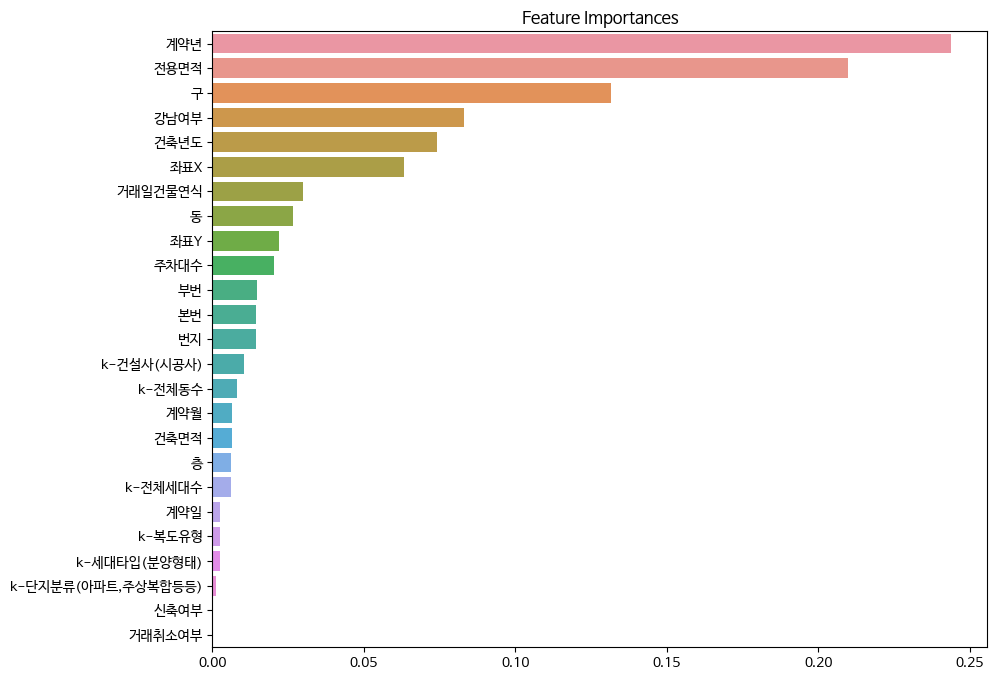

In [47]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [48]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [50]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
823047870.2609 ± 8900351.9650,계약년
536944566.6213 ± 7820460.5348,전용면적
503390054.3853 ± 908357.0511,강남여부
464525321.1065 ± 3725634.6999,구
220041093.3418 ± 1321259.2984,건축년도
164955812.8059 ± 3791409.1530,좌표X
81769146.1616 ± 812894.8077,동
77491296.2992 ± 1140328.2482,좌표Y
68289406.9442 ± 780157.3094,거래일건물연식
48265561.3721 ± 290119.0346,부번


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [ ]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [ ]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [ ]:
X_val_sort.head()

- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [ ]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [ ]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
display(error_top100.head(1))
display(best_top100.head(1))

- 이제 분포를 비교해보도록 하겠습니다.

In [ ]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

In [ ]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

In [ ]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

## 7. Output File Save

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)